In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import img_to_array, load_img
import random


np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [3]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model

In [4]:
DATA_DIR = '/content/drive/MyDrive/Brain_Stroke'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'Train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'Validation')

In [23]:
IMG_SIZE = 96
CATEGORIES = []
for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

['Normal', 'Stroke']


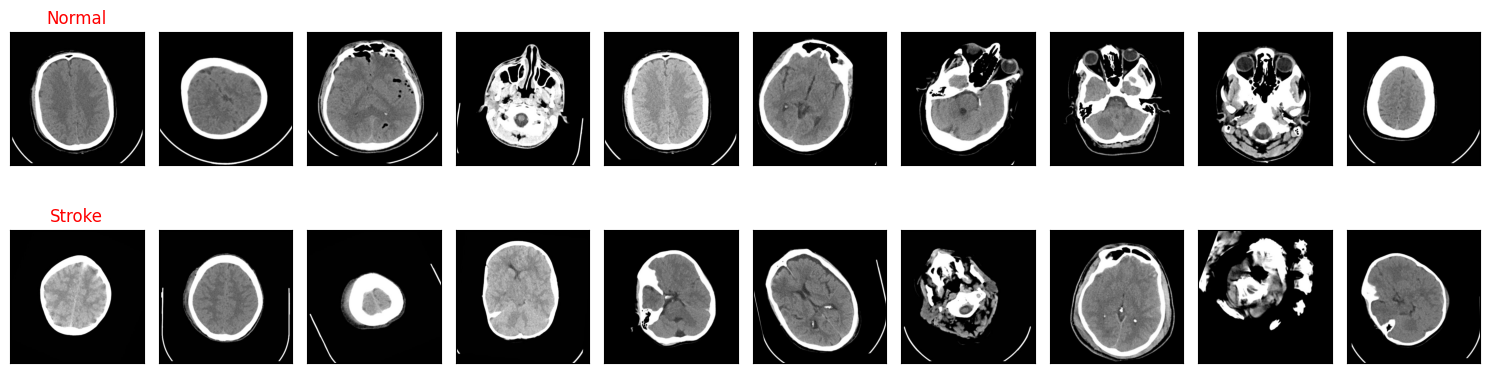

In [ ]:
plt.figure(figsize=(15, 20), facecolor='white')
i = 1
for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    random.shuffle(image_list)
    image_list = image_list[:10]
    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)
        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1], :] = img_array
        plt.subplot(10, 10, i)
        plt.imshow(white_background)
        if i % 10 == 1:
            plt.title(c, color='red')
        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

In [25]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 1840/1840 [00:10<00:00, 177.26it/s]

3680


In [26]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 272/272 [00:01<00:00, 203.91it/s]

736


In [27]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (3680, 96, 96, 3) Y_train= (3680,)


In [28]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

X_test= (736, 96, 96, 3) Y_test= (736,)


### VGG16(pretrained)

In [29]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
vgg16_basic_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
for layer in vgg16_basic_model.layers:
    layer.trainable = False
vgg16_model = Sequential()
vgg16_model.add(vgg16_basic_model)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(128, activation='relu'))
vgg16_model.add(Dense(10, activation='softmax'))
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
vgg16_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [30]:
vgg16_pretrained = vgg16_model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), batch_size=128)

Epoch 1/100
29/29 [==============================] - 10s 231ms/step - loss: 1.0410 - accuracy: 0.4870 - val_loss: 0.7233 - val_accuracy: 0.4524
Epoch 2/100
29/29 [==============================] - 4s 129ms/step - loss: 0.6695 - accuracy: 0.6049 - val_loss: 0.5990 - val_accuracy: 0.6984
Epoch 3/100
29/29 [==============================] - 4s 129ms/step - loss: 0.6402 - accuracy: 0.6481 - val_loss: 0.6107 - val_accuracy: 0.7106
Epoch 4/100
29/29 [==============================] - 4s 129ms/step - loss: 0.6136 - accuracy: 0.6818 - val_loss: 0.6073 - val_accuracy: 0.6821
Epoch 5/100
29/29 [==============================] - 4s 129ms/step - loss: 0.5955 - accuracy: 0.7065 - val_loss: 0.5495 - val_accuracy: 0.7772
Epoch 6/100
29/29 [==============================] - 4s 125ms/step - loss: 0.5742 - accuracy: 0.7234 - val_loss: 0.5358 - val_accuracy: 0.7663
Epoch 7/100
29/29 [==============================] - 4s 126ms/step - loss: 0.5616 - accuracy: 0.7293 - val_loss: 0.5338 - val_accuracy: 0.771

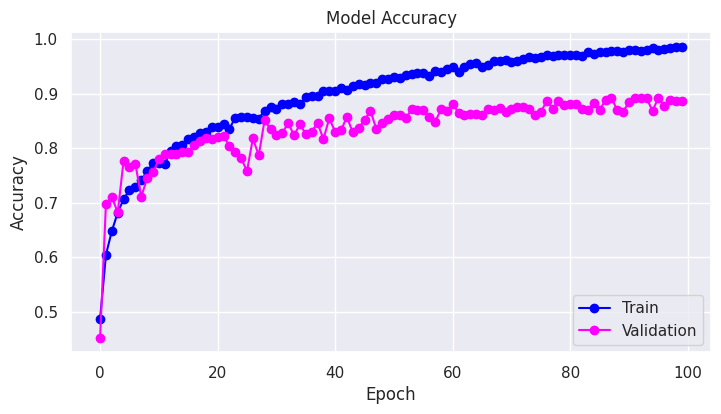

In [31]:
#  "Accuracy"
import seaborn as sns
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(vgg16_pretrained.history['accuracy'], 'o-',color="blue")
plt.plot(vgg16_pretrained.history['val_accuracy'] ,'o-', color="magenta")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

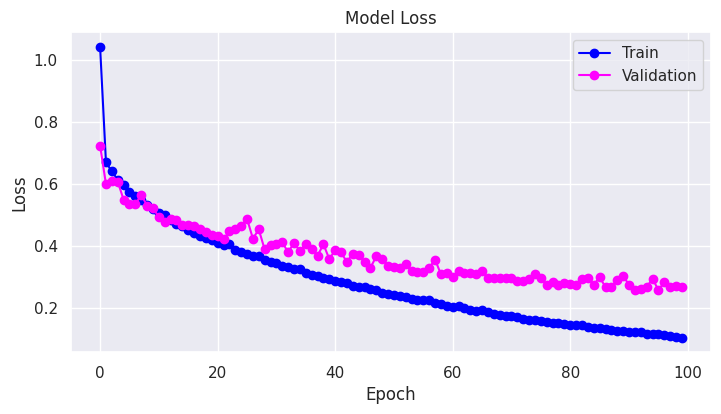

In [32]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(vgg16_pretrained.history['loss'],'o-', color="blue")
plt.plot(vgg16_pretrained.history['val_loss'],'o-', color="magenta")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [33]:
test_loss, test_acc = vgg16_model.evaluate(X_test, Y_test)
train_loss, train_acc=vgg16_model.evaluate(X_train, Y_train)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
print('\nTrain Accuracy:', train_acc)
print('\nTrain Loss:', train_loss)

115/115 [==============================] - 3s 28ms/step - loss: 0.1052 - accuracy: 0.9840

Test Accuracy: 0.885869562625885

Test Loss: 0.2682155966758728

Train Accuracy: 0.9839673638343811

Train Loss: 0.10515499860048294


In [34]:
score = vgg16_model.evaluate(X_test,Y_test,verbose=0)

print("Accuracy: ",np.round(score[1]*100,3),"%")

Accuracy:  88.587 %


In [35]:
testX_arg = np.argmax(Y_test)
y_pred = np.argmax(vgg16_model.predict(X_test), axis=1)
y_true = np.argmax(Y_test)
print(y_pred)
print(y_pred.shape)

23/23 [==============================] - 1s 27ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0
 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1

In [36]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm

array([[411,  53],
       [ 31, 241]])

In [37]:
print(classification_report(Y_test, y_pred,  digits=3,target_names = CATEGORIES))

              precision    recall  f1-score   support

      Normal      0.930     0.886     0.907       464
      Stroke      0.820     0.886     0.852       272

    accuracy                          0.886       736
   macro avg      0.875     0.886     0.879       736
weighted avg      0.889     0.886     0.887       736



In [38]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['Normal', 'Stroke'] , columns = ['Normal', 'Stroke'])

<Axes: title={'center': 'Confusion Matrix'}>

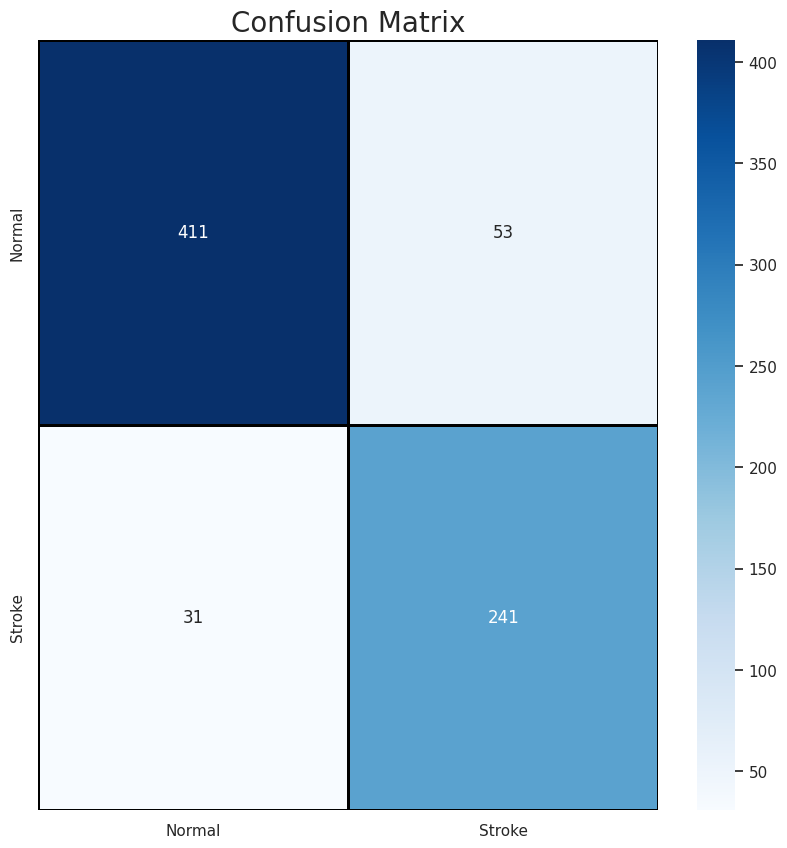

In [39]:
plt.figure(figsize = (10,10))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

23/23 [==============================] - 0s 17ms/step


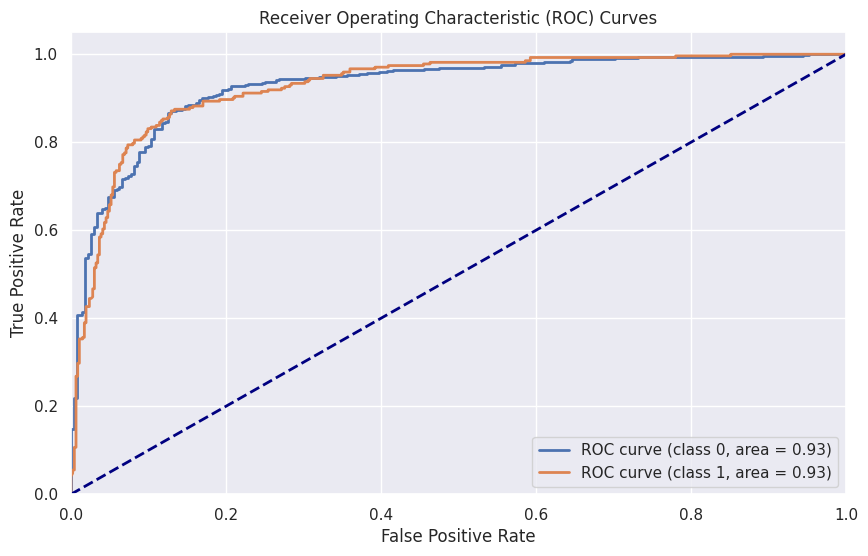

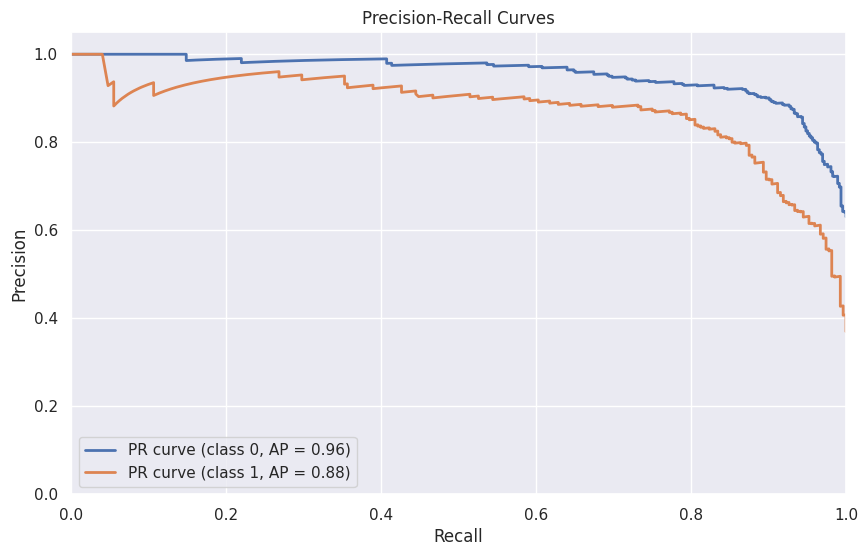

In [22]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
bcnn_model_output = vgg16_model.predict(X_test)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, bcnn_model_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, bcnn_model_output[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()